### Libraries

In [1]:
! pip install tensorflow_decision_forests
! pip install catboost

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 94.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 88.8 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.0
    Uninstalling tensorboard-2.17.0:
      Successfully uninstalled tensorboard-2.17.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorflow
    Found existing installatio

In [2]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn import metrics

from catboost import CatBoostClassifier
import xgboost as xgb
import lightgbm as lgb

from yellowbrick.classifier import ConfusionMatrix, ROCAUC
from yellowbrick.exceptions import YellowbrickWarning

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### Data Analysis and Processing

In [21]:
df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

In [22]:
df

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58640,58640,34,120000,MORTGAGE,5.0,EDUCATION,D,25000,15.95,0.21,Y,10,0
58641,58641,28,28800,RENT,0.0,MEDICAL,C,10000,12.73,0.35,N,8,1
58642,58642,23,44000,RENT,7.0,EDUCATION,D,6800,16.00,0.15,N,2,1
58643,58643,22,30000,RENT,2.0,EDUCATION,A,5000,8.90,0.17,N,3,0


In [23]:
print(df.columns)

Index(['id', 'person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'loan_status'],
      dtype='object')


In [24]:
print('\n Train Dataset summary : \n')

pd.concat([
            pd.DataFrame(df.count()).T.rename(index={0: 'count'}),
           pd.DataFrame(df.nunique()).T.rename(index={0: 'number of unique'}),
           pd.DataFrame(df.dtypes).T.rename(index={0: 'dtype'}),
           pd.DataFrame(df.isna().sum()).T.rename(index={0: 'null count'}),
           df.describe().drop('count')
          ]).T


 Train Dataset summary : 



,count,number of unique,dtype,null count,mean,std,min,25%,50%,75%,max
id,58645,58645,int64,0,29322.0,16929.497605,0.0,14661.0,29322.0,43983.0,58644.0
person_age,58645,53,int64,0,27.550857,6.033216,20.0,23.0,26.0,30.0,123.0
person_income,58645,2641,int64,0,64046.172871,37931.106979,4200.0,42000.0,58000.0,75600.0,1900000.0
person_home_ownership,58645,4,object,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
person_emp_length,58645,36,float64,0,4.701015,3.959784,0.0,2.0,4.0,7.0,123.0
loan_intent,58645,6,object,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_grade,58645,7,object,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_amnt,58645,545,int64,0,9217.556518,5563.807384,500.0,5000.0,8000.0,12000.0,35000.0
loan_int_rate,58645,362,float64,0,10.677874,3.034697,5.42,7.88,10.75,12.99,23.22
loan_percent_income,58645,61,float64,0,0.159238,0.091692,0.0,0.09,0.14,0.21,0.83


In [25]:
print('\n Test Dataset summary : \n')

pd.concat([
            pd.DataFrame(test_df.count()).T.rename(index={0: 'count'}),
           pd.DataFrame(test_df.nunique()).T.rename(index={0: 'number of unique'}),
           pd.DataFrame(test_df.dtypes).T.rename(index={0: 'dtype'}),
           pd.DataFrame(test_df.isna().sum()).T.rename(index={0: 'null count'}),
           test_df.describe().drop('count')
          ]).T


 Test Dataset summary : 



,count,number of unique,dtype,null count,mean,std,min,25%,50%,75%,max
id,39098,39098,int64,0,78193.5,11286.764749,58645.0,68419.25,78193.5,87967.75,97742.0
person_age,39098,52,int64,0,27.566781,6.032761,20.0,23.0,26.0,30.0,94.0
person_income,39098,2196,int64,0,64060.460842,37955.828705,4000.0,42000.0,58000.0,75885.0,1900000.0
person_home_ownership,39098,4,object,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
person_emp_length,39098,31,float64,0,4.687068,3.868395,0.0,2.0,4.0,7.0,42.0
loan_intent,39098,6,object,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_grade,39098,7,object,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_amnt,39098,482,int64,0,9251.466188,5576.25468,700.0,5000.0,8000.0,12000.0,35000.0
loan_int_rate,39098,336,float64,0,10.661216,3.02022,5.42,7.88,10.75,12.99,22.11
loan_percent_income,39098,63,float64,0,0.159573,0.091633,0.0,0.09,0.14,0.21,0.73


In [26]:
df.drop(columns = ['id'], inplace=True)
df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
58640,34,120000,MORTGAGE,5.0,EDUCATION,D,25000,15.95,0.21,Y,10,0
58641,28,28800,RENT,0.0,MEDICAL,C,10000,12.73,0.35,N,8,1
58642,23,44000,RENT,7.0,EDUCATION,D,6800,16.00,0.15,N,2,1
58643,22,30000,RENT,2.0,EDUCATION,A,5000,8.90,0.17,N,3,0


In [27]:
print('Categorical value of person_home_ownership: ', df.person_home_ownership.unique())
print('Categorical value of loan_intent: ', df.loan_intent.unique())
print('Categorical value of loan_grade: ', df.loan_grade.unique())
print('Categorical value of cb_person_default_on_file: ', df.cb_person_default_on_file.unique())

Categorical value of person_home_ownership:  ['RENT' 'OWN' 'MORTGAGE' 'OTHER']
Categorical value of loan_intent:  ['EDUCATION' 'MEDICAL' 'PERSONAL' 'VENTURE' 'DEBTCONSOLIDATION'
 'HOMEIMPROVEMENT']
Categorical value of loan_grade:  ['B' 'C' 'A' 'D' 'E' 'F' 'G']
Categorical value of cb_person_default_on_file:  ['N' 'Y']


In [28]:
df_tensor = df.copy()

cb_person_default_on_file_mapping = {'Y' : 1, 'N' : 0}
loan_grade_mapping = {'A' : 7, 'B' : 6, 'C' : 5, 'D' : 4, 'E' : 3, 'F' : 2, 'G' : 1}
person_home_ownership_mapping = {'OWN' : 4, 'MORTGAGE' : 3, 'RENT' : 2, 'OTHER' : 1}

In [29]:
df['cb_person_default_on_file'] = df['cb_person_default_on_file'].map(cb_person_default_on_file_mapping)
df['loan_grade'] = df['loan_grade'].map(loan_grade_mapping)
df['person_home_ownership'] = df['person_home_ownership'].map(person_home_ownership_mapping)

In [30]:
df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,2,0.0,EDUCATION,6,6000,11.49,0.17,0,14,0
1,22,56000,4,6.0,MEDICAL,5,4000,13.35,0.07,0,2,0
2,29,28800,4,8.0,PERSONAL,7,6000,8.90,0.21,0,10,0
3,30,70000,2,14.0,VENTURE,6,12000,11.11,0.17,0,5,0
4,22,60000,2,2.0,MEDICAL,7,6000,6.92,0.10,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
58640,34,120000,3,5.0,EDUCATION,4,25000,15.95,0.21,1,10,0
58641,28,28800,2,0.0,MEDICAL,5,10000,12.73,0.35,0,8,1
58642,23,44000,2,7.0,EDUCATION,4,6800,16.00,0.15,0,2,1
58643,22,30000,2,2.0,EDUCATION,7,5000,8.90,0.17,0,3,0


In [31]:
label_encoder = LabelEncoder()
df['loan_intent'] = label_encoder.fit_transform(df['loan_intent'])

In [32]:
df.duplicated().sum()

0

In [33]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,2,0.0,1,6,6000,11.49,0.17,0,14,0
1,22,56000,4,6.0,3,5,4000,13.35,0.07,0,2,0
2,29,28800,4,8.0,4,7,6000,8.90,0.21,0,10,0
3,30,70000,2,14.0,5,6,12000,11.11,0.17,0,5,0
4,22,60000,2,2.0,3,7,6000,6.92,0.10,0,3,0


### Visualization

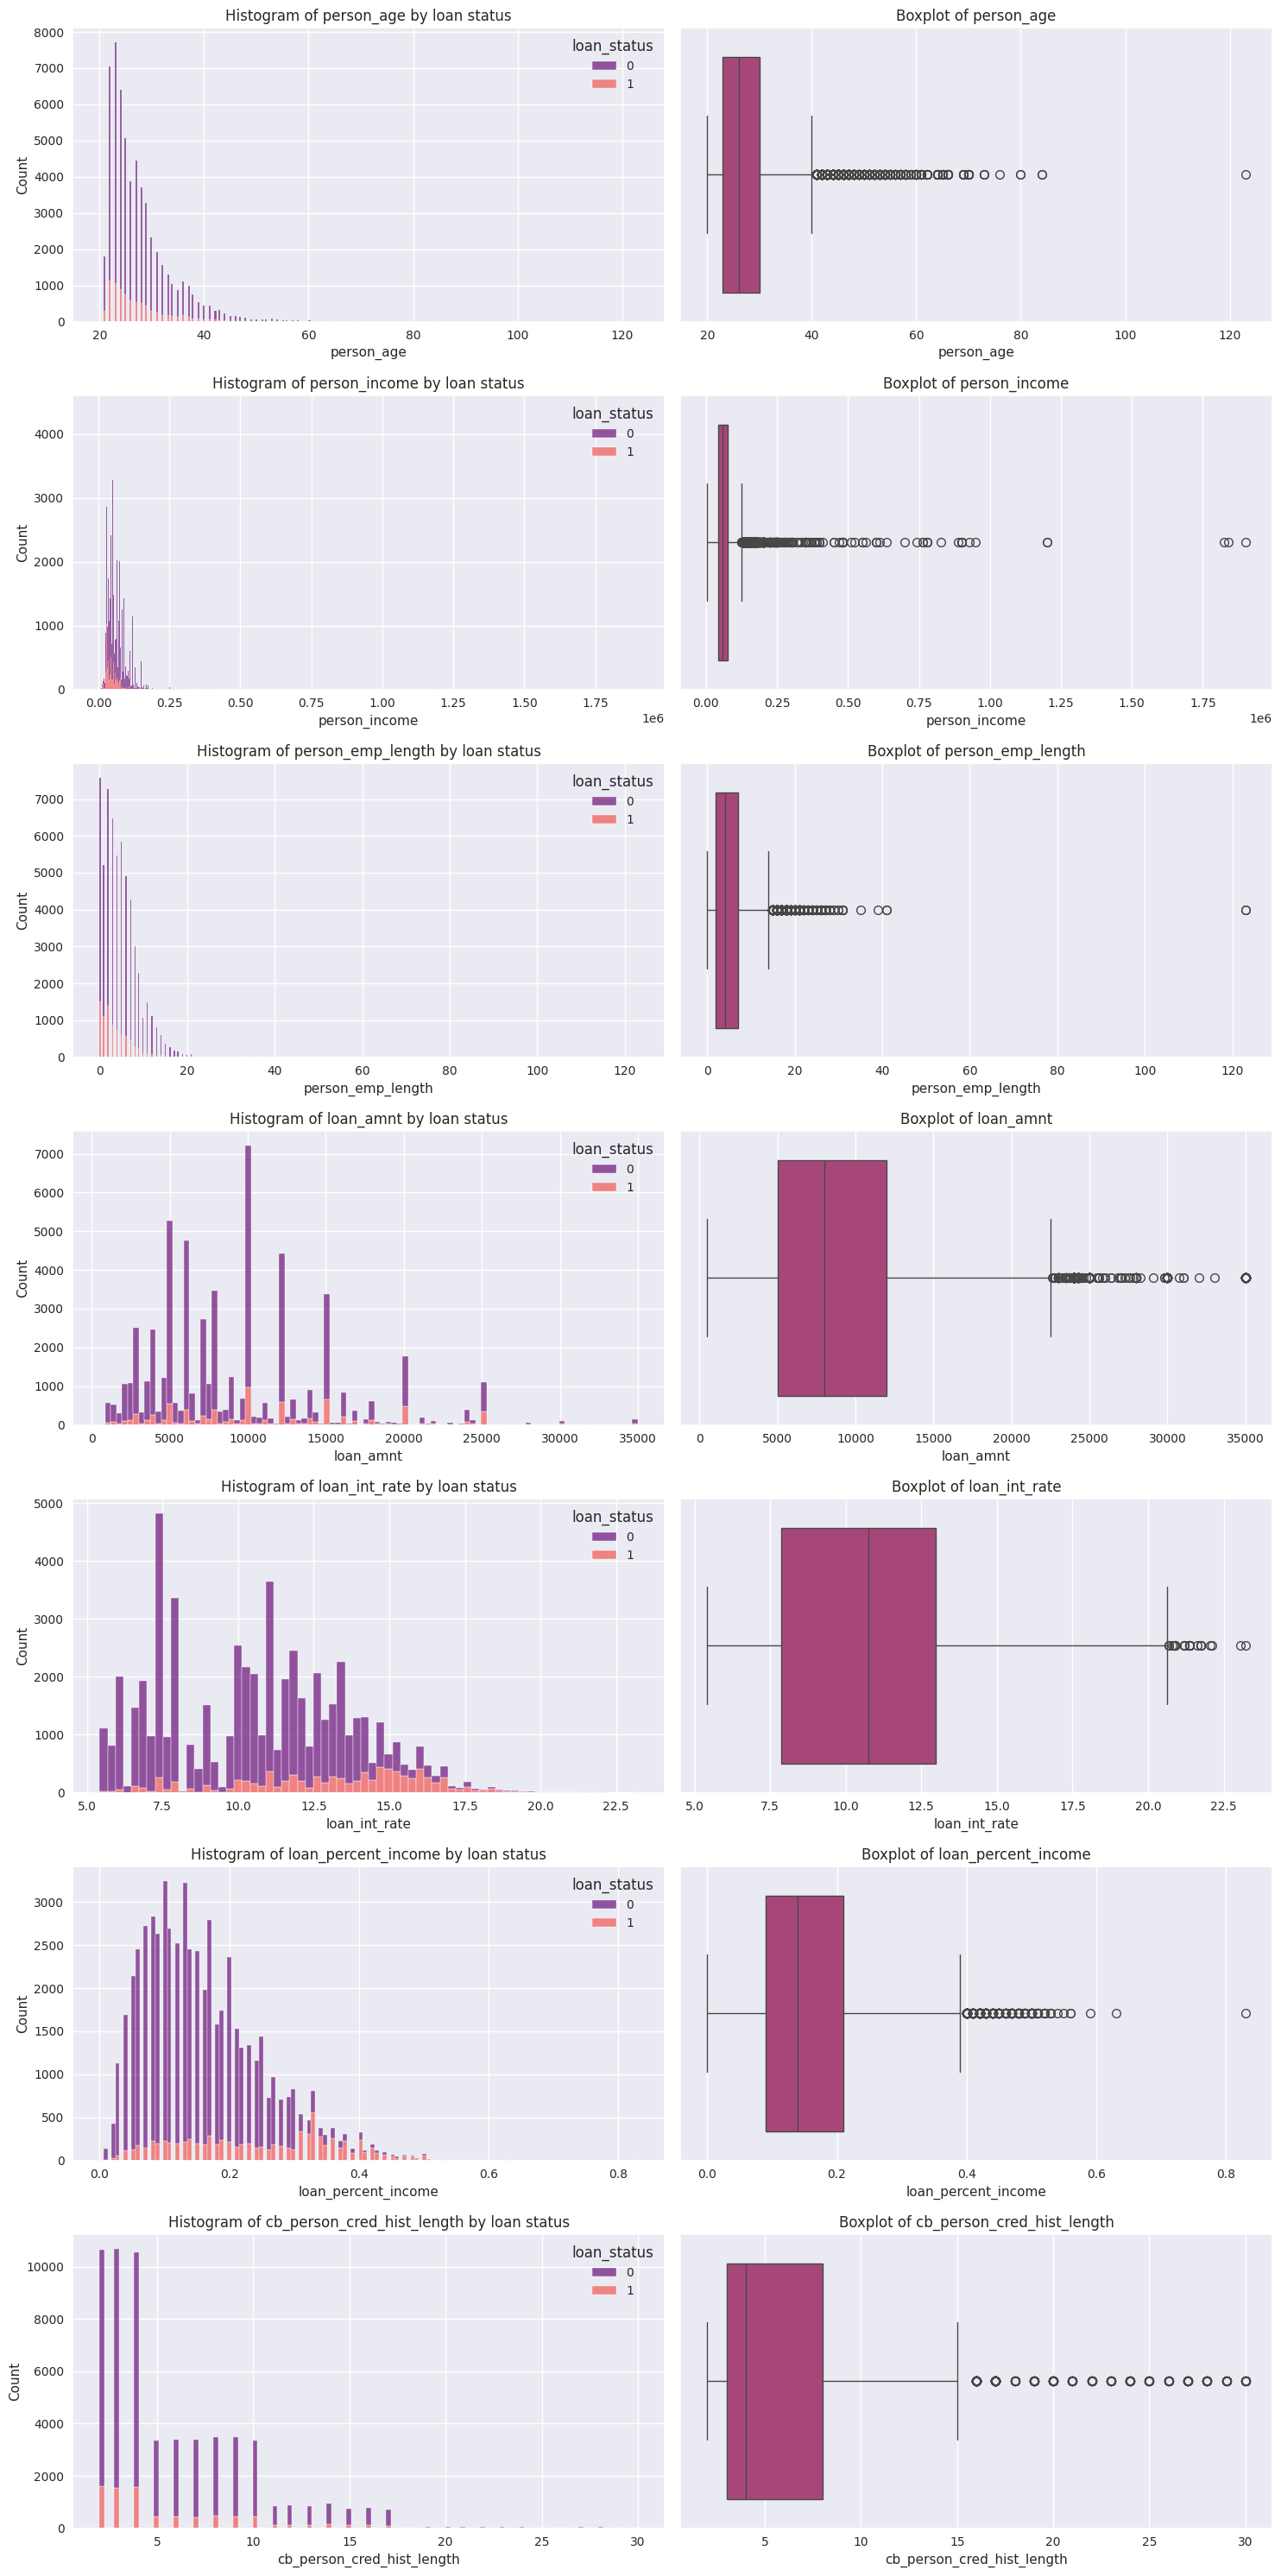

In [34]:
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set_style('darkgrid')

list_of_columns = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
fig, axs = plt.subplots(len(list_of_columns), 2, figsize=(15, 30))

for i, columns_name in enumerate(list_of_columns):
    sns.histplot(data=df, x=columns_name, hue='loan_status',
                 multiple='stack', palette='magma', ax=axs[i, 0])

    axs[i, 0].set_title(f'Histogram of {columns_name} by loan status')

    sns.boxplot(data=df, x=columns_name, palette='magma', ax=axs[i, 1])

    axs[i, 1].set_title(f'Boxplot of {columns_name}')

plt.tight_layout()

plt.show()

warnings.simplefilter(action='default', category=FutureWarning)

In [35]:
df = df[df.person_age < 100]
df = df[df.person_emp_length < 100]

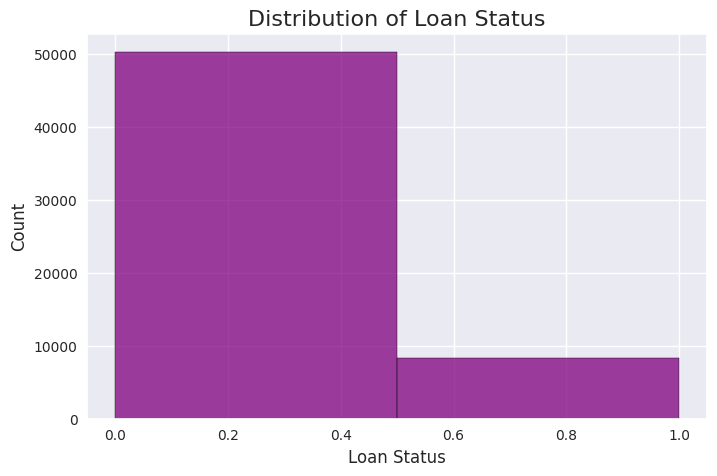

In [36]:
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.figure(figsize=(8, 5))

sns.histplot(data=df, x='loan_status', bins=2, color='purple', edgecolor='black')

plt.title('Distribution of Loan Status', fontsize=16)
plt.xlabel('Loan Status', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.show()

warnings.simplefilter(action='default', category=FutureWarning)

### Logistic Regression

In [37]:
nan_counts = df.isna().sum()
print(nan_counts)

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64


In [ ]:
results = []

X = df.drop(columns=['loan_status'])
y = df['loan_status']

Scaler = MinMaxScaler(feature_range=(0, 1))
norm_x = Scaler.fit_transform(X)
X_norm = pd.DataFrame(norm_x, columns=list(X.columns))

x_train1, x_test1, y_train1, y_test1 = train_test_split(X_norm, y, test_size=0.2, random_state=42)

solver_penalties = [
    ('lbfgs', ['l2', None]),
    ('liblinear', ['l1', 'l2']),
    ('newton-cg', ['l2', None]),
    ('sag', ['l2', None]),
    ('saga', ['elasticnet', 'l1', 'l2', None])
]

for solver, penalties in solver_penalties:
    for C in np.arange(1, 11):
        for penalty in penalties:
            if penalty == 'elasticnet':
                l1_ratio = 0.5
                clf = LogisticRegression(solver=solver, C = C, random_state = 42, penalty = penalty, l1_ratio=l1_ratio, max_iter=10000)
            elif penalty is None:
                clf = LogisticRegression(solver=solver, random_state = 42, max_iter = 10000, penalty = None)
            else:
                clf = LogisticRegression(solver=solver, random_state = 42, max_iter = 10000, penalty = penalty, C = C)

            clf.fit(x_train1, y_train1)
            y_pred1 = clf.predict(x_test1)
            cm = metrics.confusion_matrix(y_test1, y_pred1)
            accuracy = metrics.accuracy_score(y_test1, y_pred1)
            precision = metrics.precision_score(y_test1, y_pred1)
            recall = metrics.recall_score(y_test1, y_pred1)
            results.append((solver, penalty, C, accuracy, precision, recall, cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]))

results_df = pd.DataFrame(results, columns=['solver', 'penalty', 'C', 'accuracy', 'precision', 'recall', 'TN', 'FP', 'FN', 'TP'])
results_df.sort_values(by='accuracy', ascending=False, inplace=True)
results_df.reset_index(drop=True, inplace=True)
display(results_df)

print(f'\n the best result is for {results_df["solver"][0]} Solver , penalty : {results_df["penalty"][0]} and C : {results_df["C"][0]} which has accuracy of :', results_df['accuracy'][0])
print('\n')

sns.heatmap([[results_df['TN'][0], results_df['FP'][0]],
             [results_df['FN'][0], results_df['TP'][0]]], annot=True, fmt='d', cmap='viridis')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

best_solver = results_df["solver"][0]
best_clf = LogisticRegression(solver=best_solver, max_iter=1000, C=10, random_state=0)
best_clf.fit(x_train1, y_train1)
y_pred_best = best_clf.predict(x_test1)

visualizer = ROCAUC(best_clf)
visualizer.fit(x_train1, y_train1)
visualizer.score(x_test1, y_test1)
visualizer.show();

### KNN

In [ ]:
results = []

X = df.drop(columns['loan_status'])
y = df['loan_status']

Scaler = MinMaxScaler(feature_range = (0, 1))
norm_x = Scaler.fit_transform(X)
X_norm = pd.DataFrame(norm_x, columns = list(X.columns))

x_train, x_test, y_train, y_test = train_test_split(X_norm, y, test_size = 0.2, random_state = 0)

for n_neighbors in range(1, 21):
  clf = KNeighborsClassifier(n_neighbors = n_neighbors)
  clf.fit(x_train, y_train)
  y_pred = clf.predict(x_test)
  cm = matrics.confusion_matrix(y_test, y_pred)
  accuracy = metrics.accuracy_score(y_test, y_pred)
  precision = metrics.precision_score(y_test, y_pred)
  recall = metrics.recall_score(y_test, y_pred)
  results.append((n_neighbors, clf.score(x_test, y_test), clf.score(x_train, y_train), precision, recall, cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]))

results_df = pd.DataFrame(results, columns = ['n_neighbors', 'test_accuracy', 'train_accuracy', 'precision', 'recall', 'TN', 'FP', 'FN', 'TP'])
results_df.sort_values(by = 'test_accuracy', ascending = False, inplace = True)
display(results_df)

print(f'\n the best result is for {results_df["n_neighbors"][0]} neighbors which has accuracy of :', results_df['test_accuracy'][0])
print('\n')

sns.heatmap([[results_df['TN'][0], results_df['FP'][0]],
            [results_df['FN'][0], results_df['TP'][0]]], annot=True, fmt='d', cmap='viridis')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

best_n_neighbors = results_df["n_neighbors"][0]
best_clf = KNeighborsClassifier(n_neighbors = best_n_neighbors)
best_clf.fit(x_train, y_train)
y_pred_best = best_clf.predict(x_test)

visualizer = ROCAUC(best_clf)
visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
visualizer.show();

results_df.sort_values(by = 'n_neighbors', ascending=True, inplace =True)
results_df.reset_index(drop = True, inplace =True)

plt.figure(figsize = (15, 5))
plt.plot(results_df['n_neighbors'], results_df['Accuracy of train'], label = 'Accuracy of training set')
plt.plot(results_df['n_neighbors'], results_df['Accuracy of test'], label = 'Accuracy of test set')
plt.ylabel('Accuracy')
plt.xlabel('Number of neighbores')
plt.grid()
plt.show()
